In [1]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import pingouin as pg

df = pd.read_csv('data/survey_results_public.csv')

##
## Stop outs from using scientific notation
##
pd.set_option('display.float_format', '{:.6f}'.format)

##
## Filtering responses which are not professional software developers in USA, UK or Germany that provided compensation information
##
df.dropna(subset=['CompTotal'], inplace=True)
df = df[df['MainBranch'] == 'I am a developer by profession']
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['Currency'].isin(['EUR European Euro', 'USD\tUnited States dollar', 'GBP\tPound sterling'])]
df = df[df[['Currency', 'Country']].apply(tuple, axis=1).isin([('USD\tUnited States dollar', 'United States of America'), ('EUR European Euro', 'Germany'), ('GBP\tPound sterling', 'United Kingdom of Great Britain and Northern Ireland')])]
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['DevType'].str.contains('Developer', na=False)]

##
## Drop columns which are not used
##

df = df[['EdLevel',
         'LearnCode', 
         'LearnCodeOnline', 
         'YearsCode', 
         'YearsCodePro', 
         'DevType', 
         'Country', 
         'LanguageHaveWorkedWith', 
         'LanguageWantToWorkWith', 
         'PlatformHaveWorkedWith', 
         'PlatformWantToWorkWith',
         'WebframeHaveWorkedWith', 
         'WebframeWantToWorkWith', 
         'EmbeddedHaveWorkedWith', 
         'EmbeddedWantToWorkWith', 
         'MiscTechHaveWorkedWith', 
         'MiscTechWantToWorkWith', 
         'ToolsTechHaveWorkedWith', 
         'ToolsTechWantToWorkWith', 
         'WorkExp', 
         'ConvertedCompYearly']]

##
## Break the "HaveWorkdWith" and "WantToWorkWith" columns down into a column for each language
##

WorkWithList = [
    'LanguageHaveWorkedWith', 
    'LanguageWantToWorkWith', 
    'PlatformHaveWorkedWith', 
    'PlatformWantToWorkWith',
    'WebframeHaveWorkedWith', 
    'WebframeWantToWorkWith', 
    'EmbeddedHaveWorkedWith', 
    'EmbeddedWantToWorkWith', 
    'MiscTechHaveWorkedWith', 
    'MiscTechWantToWorkWith', 
    'ToolsTechHaveWorkedWith', 
    'ToolsTechWantToWorkWith'
]

for WorkWith in WorkWithList:
    df_workwith = df[WorkWith].str.get_dummies(sep=';')
    df_workwith = df_workwith.add_prefix(WorkWith + '_')
    df = pd.concat([df, df_workwith], axis=1)

##
## Set a numerical value for each education level
##

education_mapping = {
    'Primary/elementary school': 1,
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2,
    'Some college/university study without earning a degree': 3,
    'Associate degree (A.A., A.S., etc.)': 4,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 6,
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 7
}
df['EdLevelNumeric'] = df['EdLevel'].map(education_mapping)

##
## Drop known bad cols which contain very little to no data
##

cols_to_drop = [
    'PlatformWantToWorkWith_PythonAnywhere', 
    'WebframeWantToWorkWith_Yii 2', 
    'EmbeddedHaveWorkedWith_CUTE'
]
df = df.drop(columns=cols_to_drop)

##
## Create a dataframe per country
##

df_GER = df[df['Country'] == 'Germany']
df_UK  = df[df['Country'] == 'United Kingdom of Great Britain and Northern Ireland']
df_USA = df[df['Country'] == 'United States of America']


##
## Remove Non Numeric Columns
##
df_GER = df_GER.select_dtypes(include='number')
df_UK  = df_UK.select_dtypes(include='number')
df_USA = df_USA.select_dtypes(include='number')


In [2]:
##
## Perform a partical correlation between each variable and Total Compensation. Control for all other variables as covarients.
##

dependent = 'ConvertedCompYearly'

independent_list = df_USA.columns.tolist()
independent_list.remove(dependent)

partial_corr_df = pd.DataFrame()
for independent in independent_list:

    covariates = df_GER.columns.tolist()
    covariates.remove(independent)
    covariates.remove(dependent)

    partial_corr = pg.partial_corr(data=df_USA, 
                                   y=independent, 
                                   x=dependent, 
                                   # covar=covariates,
                                   method='spearman'
                                  )

    partial_corr.index.values[0] = independent

    # print(partial_corr)
    
    partial_corr_df = pd.concat([partial_corr_df, partial_corr])

partial_corr_df = partial_corr_df.sort_values(by='r')
partial_corr_df_sig = partial_corr_df
# partial_corr_df_sig = partial_corr_df[partial_corr_df['p-val'] < 0.05]
pd.set_option('display.max_rows', 500)
display(partial_corr_df_sig)


,n,r,CI95%,p-val
LanguageHaveWorkedWith_HTML/CSS,3102,-0.205629,"[-0.24, -0.17]",0.000000
WebframeHaveWorkedWith_ASP.NET,3102,-0.183760,"[-0.22, -0.15]",0.000000
LanguageHaveWorkedWith_C#,3102,-0.181555,"[-0.22, -0.15]",0.000000
MiscTechHaveWorkedWith_.NET Framework (1.0 - 4.8),3102,-0.170868,"[-0.2, -0.14]",0.000000
LanguageWantToWorkWith_C#,3102,-0.150063,"[-0.18, -0.12]",0.000000
LanguageHaveWorkedWith_PHP,3102,-0.149162,"[-0.18, -0.11]",0.000000
WebframeHaveWorkedWith_jQuery,3102,-0.148428,"[-0.18, -0.11]",0.000000
LanguageWantToWorkWith_HTML/CSS,3102,-0.140234,"[-0.17, -0.11]",0.000000
LanguageWantToWorkWith_PHP,3102,-0.140128,"[-0.17, -0.11]",0.000000
ToolsTechHaveWorkedWith_NuGet,3102,-0.138571,"[-0.17, -0.1]",0.000000


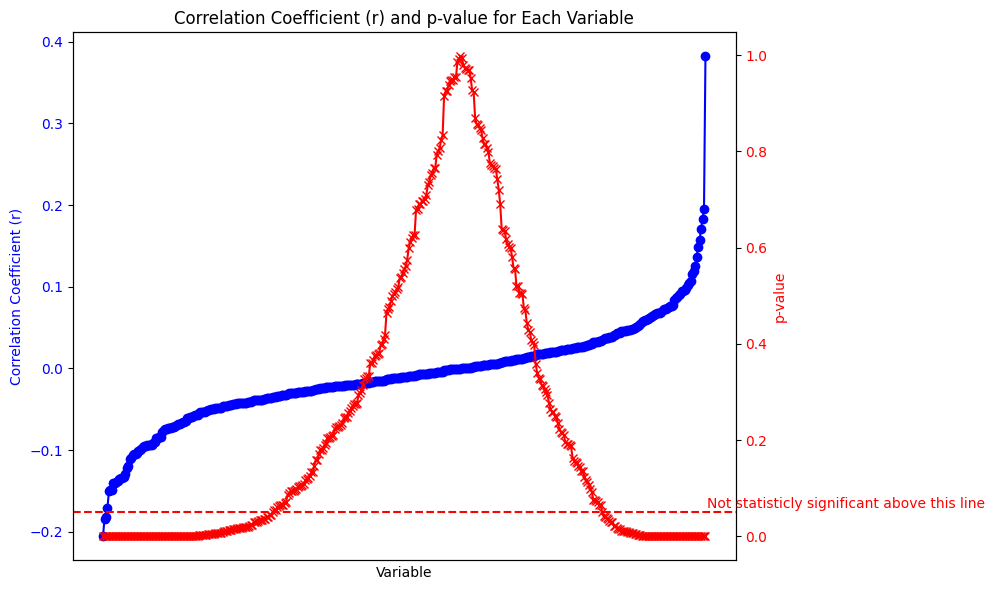

In [4]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Variable')
ax1.set_ylabel('Correlation Coefficient (r)', color='blue')
ax1.plot(partial_corr_df_sig.index, partial_corr_df_sig['r'], marker='o', color='blue', label='r')
ax1.tick_params(axis='y', labelcolor='blue')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)


ax2 = ax1.twinx() 
ax2.set_ylabel('p-value', color='red')
ax2.plot(partial_corr_df_sig.index, partial_corr_df_sig['p-val'], marker='x', color='red', label='p-val')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=0.05, color='red', linestyle='--', label='p-value cutoff (0.05)')
ax2.text(len(partial_corr_df_sig.index)-0.05, 0.05+0.01, 'Not statisticly significant above this line', color='red')

plt.title('Correlation Coefficient (r) and p-value for Each Variable')

# Display the plot
plt.tight_layout()
plt.show()
